In [1]:
import pandas as pd
import numpy as np
import os as os
import acessos as ac
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

Query

In [50]:
query = """

select 
concat(substring(cast(dt_first_install as varchar), 1, 7), '-01') as mes_instalacao
, count(distinct case when nm_media_source_appsflyer_group_big = 'organico' then id_appsflyer end) as install_organico
, count(distinct case when nm_media_source_appsflyer_group_big = 'ecred' then id_appsflyer end) as install_ecred
, count(distinct case when nm_media_source_appsflyer_group_big = 'midias sociais' then id_appsflyer end) as install_midias_sociais
, count(distinct case when nm_media_source_appsflyer_group_big = 'novos canais' then id_appsflyer end) as install_novos_canais
, count(distinct case when nm_media_source_appsflyer_group_big = 'repescagem' then id_appsflyer end) as install_repescagem
, count(distinct case when nm_media_source_appsflyer_group_big = 'mgm' then id_appsflyer end) as install_mgm
from 
growth_curated_zone.appsflyer_install
where dt_first_install < date('2023-12-01')
group by 1
order by 1

"""


In [51]:
df = ac.df_athena('flavia-costa', query)

In [46]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm
0,2020-01-01,15718,0,0,0,239,383
1,2020-02-01,21296,0,0,0,610,441
2,2020-03-01,21803,0,0,0,273,356
3,2020-04-01,15492,0,0,0,151,406
4,2020-05-01,19516,0,127,0,86,472


In [25]:
df.tail()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm
43,2023-08-01,3291091,1567,750346,1088925,19473,325063
44,2023-09-01,2699344,1557,744535,525968,56217,320280
45,2023-10-01,3203736,14,461103,348528,76208,345041
46,2023-11-01,2360023,24,396656,269316,81870,297270
47,2023-12-01,852360,5,187159,186365,46822,126048


### Exploração 

Text(0.5, 1.0, 'Instalações organico')

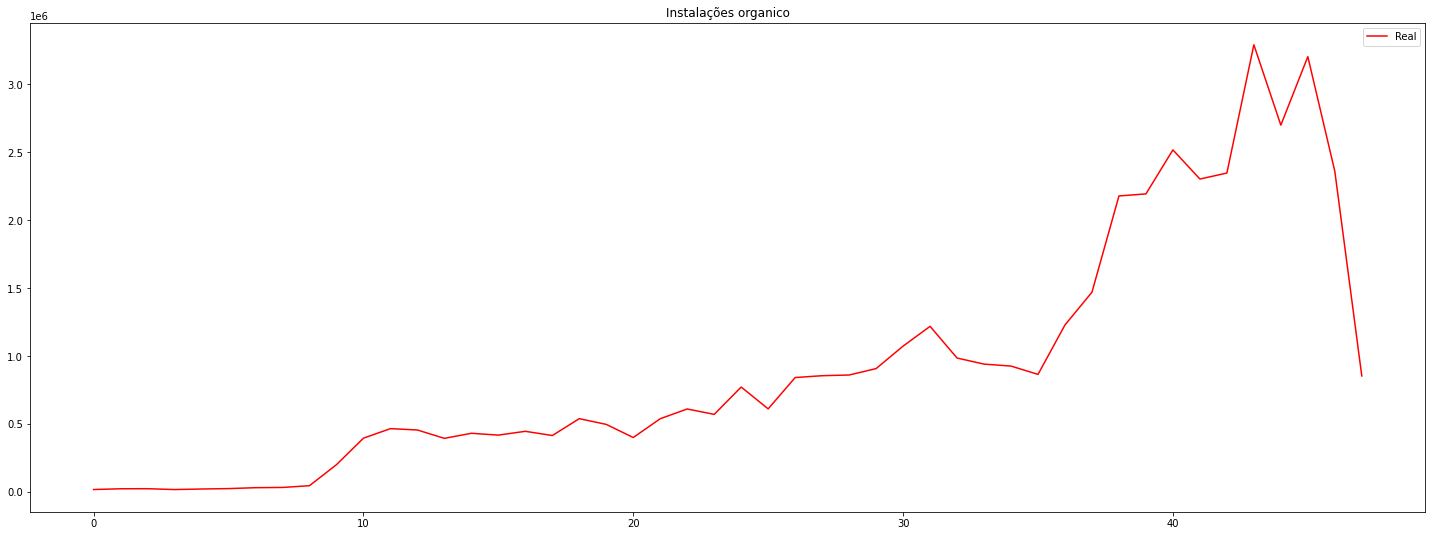

In [17]:
plt.figure(figsize=(25,9))
plt.plot(df['install_organico'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalações organico')

Text(0.5, 1.0, 'Instalaçoes Mídias Sociais')

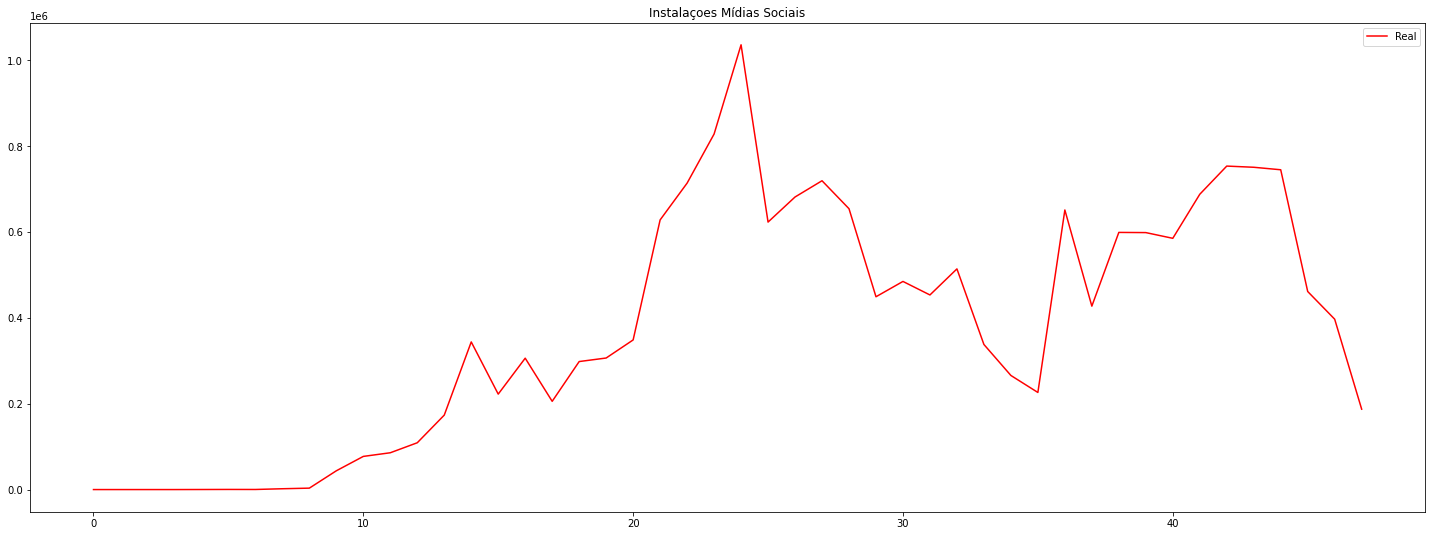

In [18]:
plt.figure(figsize=(25,9))
plt.plot(df['install_midias_sociais'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes Mídias Sociais')

Text(0.5, 1.0, 'Instalaçoes MGM')

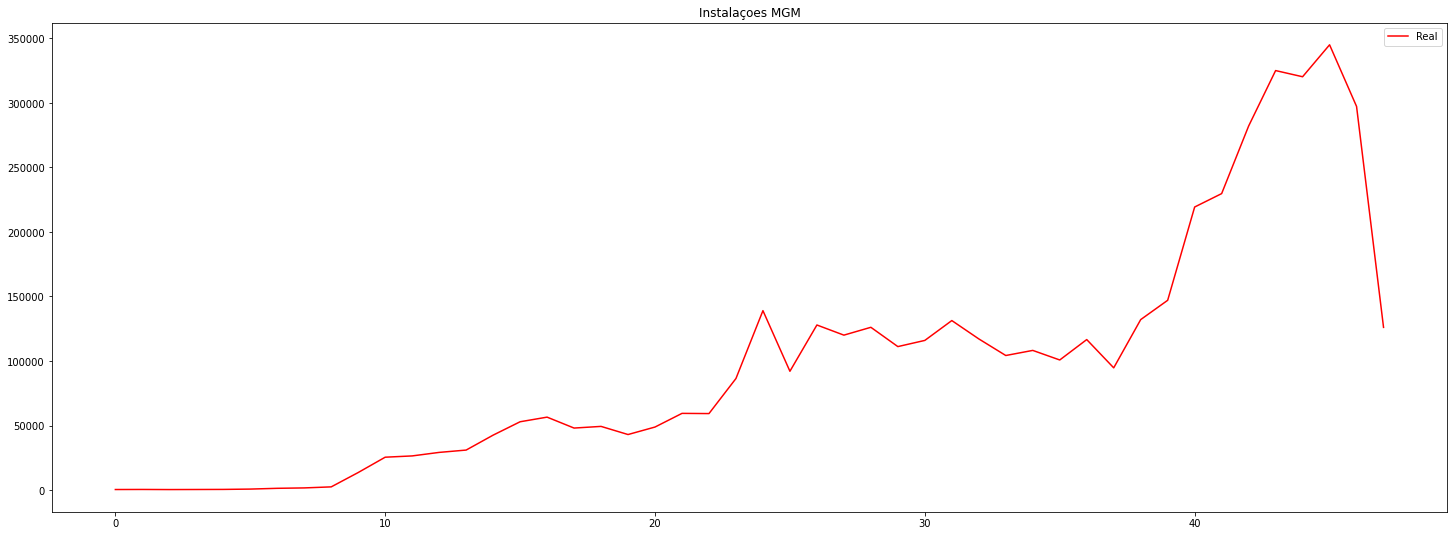

In [26]:
plt.figure(figsize=(25,9))
plt.plot(df['install_mgm'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes MGM')

## Correlações

In [20]:
id_columns = ['mes_instalacao']

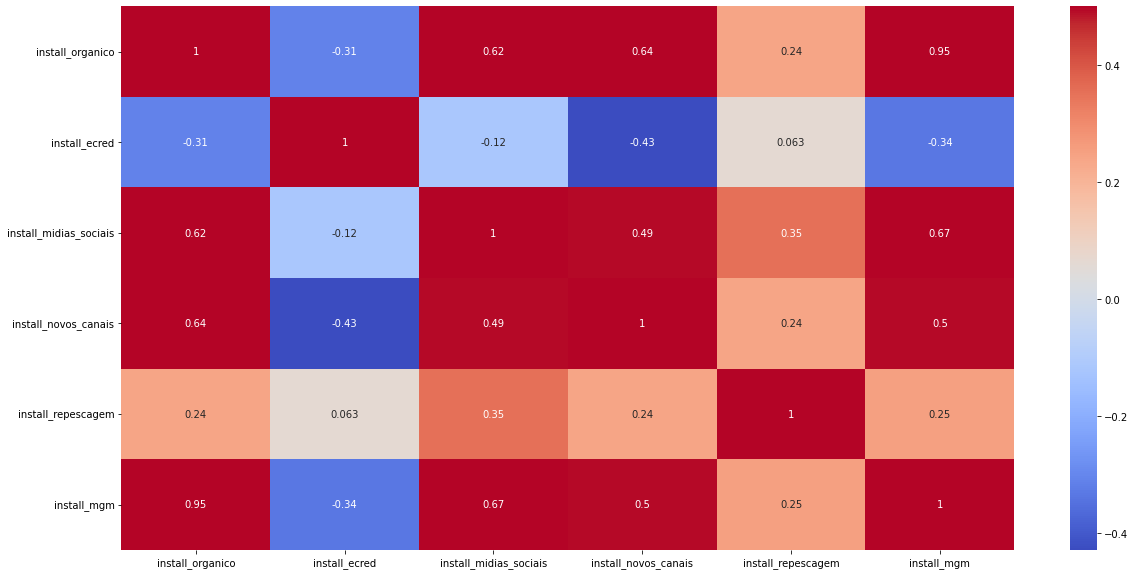

In [27]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

<Figure size 1440x720 with 0 Axes>

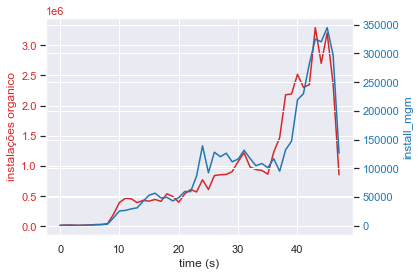

In [96]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações organico', color=color)
ax1.plot(df['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('install_mgm', color=color)  # we already handled the x-label with ax1
ax2.plot(df['install_mgm'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [29]:
df.dtypes

mes_instalacao            object
install_organico           int64
install_ecred              int64
install_midias_sociais     int64
install_novos_canais       int64
install_repescagem         int64
install_mgm                int64
dtype: object


Criando sazonais

In [30]:
#from datetime import datetime

df['mes_instalacao_dt'] = pd.to_datetime(df['mes_instalacao'])
df['ano'] = df['mes_instalacao_dt'].map(lambda x: x.strftime('%Y'))
df['mes'] = df['mes_instalacao_dt'].map(lambda x: x.strftime('%m'))

In [31]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes
0,2020-01-01,15718,0,0,0,239,383,2020-01-01,2020,01
1,2020-02-01,21295,0,0,0,611,441,2020-02-01,2020,02
2,2020-03-01,21803,0,0,0,273,356,2020-03-01,2020,03
3,2020-04-01,15492,0,0,0,151,406,2020-04-01,2020,04
4,2020-05-01,19515,0,127,0,86,472,2020-05-01,2020,05


Transformação vars

In [34]:

df['ln_install_organico'] = np.log(df['install_organico'])
df['ln_install_midias_sociais'] = np.log(df['install_midias_sociais'])
df['ln_install_novos_canais'] = np.log(df['install_novos_canais'])
df['ln_install_mgm'] = np.log(df['install_mgm'])

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Tratando missings

In [35]:
for column in df.columns:
    df[column].fillna(0, inplace = True)

In [41]:
df = df.replace([np.nan, -np.inf], 0)

Text(0.5, 1.0, 'Instalaçoes organico em log')

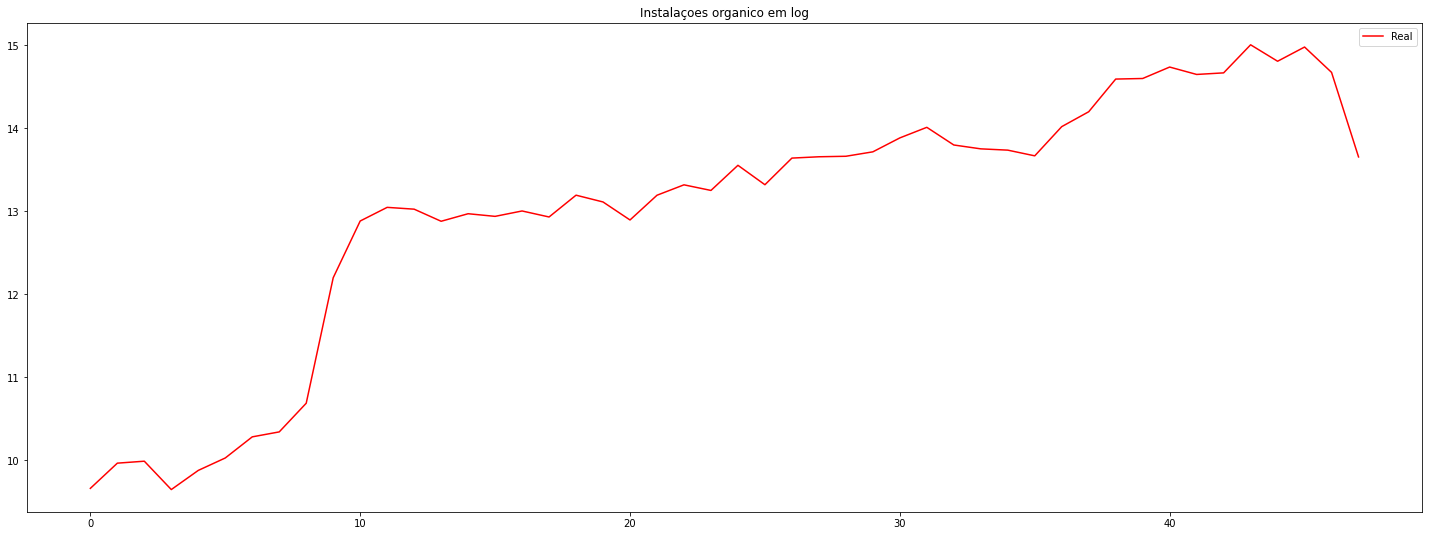

In [43]:
plt.figure(figsize=(25,9))
plt.plot(df['ln_install_organico'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes organico em log')

Text(0.5, 1.0, 'Instalaçoes MGM em log')

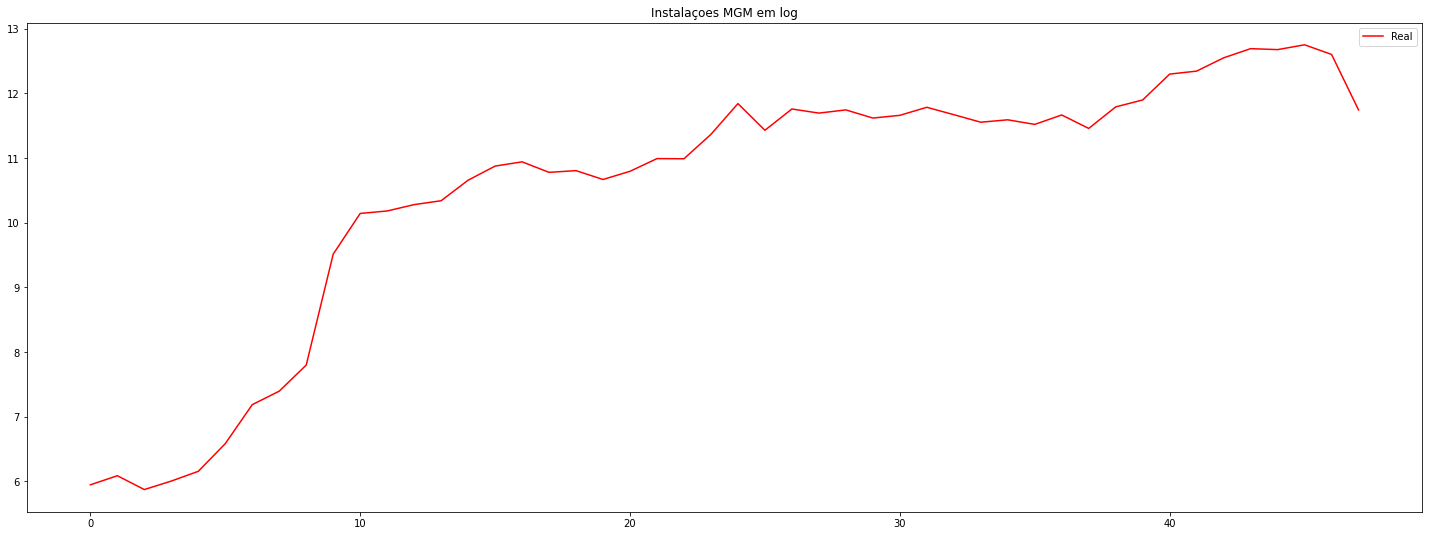

In [44]:
plt.figure(figsize=(25,9))
plt.plot(df['ln_install_mgm'], color = 'red', label = 'Real')
plt.legend()
plt.title('Instalaçoes MGM em log')

In [45]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,ln_install_organico,ln_install_midias_sociais,ln_install_novos_canais,ln_install_mgm
0,2020-01-01,15718,0,0,0,239,383,2020-01-01,2020,01,9.662562,0.000000,0.0,5.948035
1,2020-02-01,21295,0,0,0,611,441,2020-02-01,2020,02,9.966228,0.000000,0.0,6.089045
2,2020-03-01,21803,0,0,0,273,356,2020-03-01,2020,03,9.989803,0.000000,0.0,5.874931
3,2020-04-01,15492,0,0,0,151,406,2020-04-01,2020,04,9.648079,0.000000,0.0,6.006353
4,2020-05-01,19515,0,127,0,86,472,2020-05-01,2020,05,9.878939,4.844187,0.0,6.156979


### Primeiro teste modelo

In [52]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    C(ano) + 
    C(mes)
        
    """)

In [53]:
model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.987
Model:                             OLS   Adj. R-squared:                  0.979
Method:                  Least Squares   F-statistic:                     132.7
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           1.58e-23
Time:                         11:07:47   Log-Likelihood:                 14.559
No. Observations:                   48   AIC:                             6.882
Df Residuals:                       30   BIC:                             40.56
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [48]:
formula_text = ("""
    ln_install_organico ~ 
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.882
Model:                             OLS   Adj. R-squared:                  0.832
Method:                  Least Squares   F-statistic:                     17.63
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           2.07e-11
Time:                         11:01:27   Log-Likelihood:                -38.136
No. Observations:                   48   AIC:                             106.3
Df Residuals:                       33   BIC:                             134.3
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2771      0.3

Média móvel

In [49]:
#df['ma_ln_install_mgm'] = np.log(df['install_mgm'].rolling(2).mean())


In [51]:
# """ """ formula_text = ("""
    
#     ln_install_organico ~ 
#     ln_install_mgm + 
#     ln_install_novos_canais +
#     ma_ln_install_mgm +
#     ln_install_midias_sociais +
#     C(ano) + 
#     C(mes)
        
#     """)

# model = smf.ols(formula = formula_text, data = df).fit()
# print(model.summary()) """ """

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.986
Model:                             OLS   Adj. R-squared:                  0.976
Method:                  Least Squares   F-statistic:                     105.7
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           5.20e-21
Time:                         11:05:48   Log-Likelihood:                 13.848
No. Observations:                   47   AIC:                             10.30
Df Residuals:                       28   BIC:                             45.46
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [57]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  14.973018693296838


### Variáveis macroeconomicas

In [58]:
# Importa as bibliotecas
#!pip install python-bcb


     |████████████████████████████████| 71 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 4.4 MB/s eta 0:00:011
     |████████████████████████████████| 85 kB 3.5 MB/s  eta 0:00:01
ERROR: awswrangler 2.19.0 has requirement pandas!=1.5.0,<2.0.0,<=1.5.1,>=1.2.0, but you'll have pandas 1.5.3 which is incompatible.
ERROR: texthero 1.1.0 has requirement spacy<3.0.0, but you'll have spacy 3.6.0 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.3
    Uninstalling pandas-1.4.3:
      Successfully uninstalled pandas-1.4.3


In [76]:
from bcb import sgs

# Busca a série da SELIC no SGS
#selic = sgs.get({'selic':432}, start = '2020-01-01')

In [78]:
ifl_month = sgs.get({'ipca': 433,
             'igp-m': 189}, start = '2020-01-01')

# Transforma a frequência da data em mensal
ifl_month.index = ifl_month.index.to_period('M')

ConnectionError: HTTPConnectionPool(host='api.bcb.gov.br', port=80): Max retries exceeded with url: /dados/serie/bcdata.sgs.433/dados?formato=json&dataInicial=01%2F01%2F2020&dataFinal=19%2F12%2F2023 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f571abe2160>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [ ]:
ifl_month = ifl_month.reset_index()

In [ ]:
ifl_month

,Date,ipca,igp-m,mes_instalacao
0,2020-01,0.21,0.48,2020-01-01
1,2020-02,0.25,-0.04,2020-02-01
2,2020-03,0.07,1.24,2020-03-01
3,2020-04,-0.31,0.80,2020-04-01
4,2020-05,-0.38,0.28,2020-05-01
5,2020-06,0.26,1.56,2020-06-01
6,2020-07,0.36,2.23,2020-07-01
7,2020-08,0.24,2.74,2020-08-01
8,2020-09,0.64,4.34,2020-09-01
9,2020-10,0.86,3.23,2020-10-01


In [ ]:
ifl_month['mes_instalacao'] = ifl_month['Date'].astype('string') + '-01'

In [75]:
df = df.join(ifl_month.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [76]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,ln_install_organico,ln_install_midias_sociais,ln_install_novos_canais,ln_install_mgm,ma_ln_install_mgm,Date,ipca,igp-m
0,2020-01-01,15718,0,0,0,239,383,2020-01-01,2020,01,9.662562,0.000000,0.0,5.948035,NaN,2020-01,0.21,0.48
1,2020-02-01,21295,0,0,0,611,441,2020-02-01,2020,02,9.966228,0.000000,0.0,6.089045,6.021023,2020-02,0.25,-0.04
2,2020-03-01,21803,0,0,0,273,356,2020-03-01,2020,03,9.989803,0.000000,0.0,5.874931,5.987707,2020-03,0.07,1.24
3,2020-04-01,15492,0,0,0,151,406,2020-04-01,2020,04,9.648079,0.000000,0.0,6.006353,5.942799,2020-04,-0.31,0.80
4,2020-05-01,19515,0,127,0,86,472,2020-05-01,2020,05,9.878939,4.844187,0.0,6.156979,6.084499,2020-05,-0.38,0.28


### Gráfico installs organico x inflação

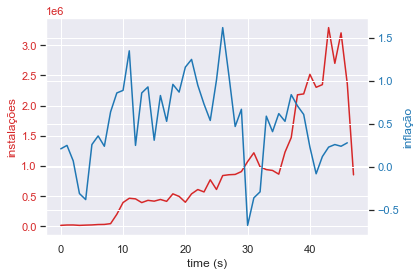

In [87]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações', color=color)
ax1.plot(df['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('inflação', color=color)  # we already handled the x-label with ax1
ax2.plot(df['ipca'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [79]:
df.columns

Index(['mes_instalacao', 'install_organico', 'install_ecred',
       'install_midias_sociais', 'install_novos_canais', 'install_repescagem',
       'install_mgm', 'mes_instalacao_dt', 'ano', 'mes', 'ln_install_organico',
       'ln_install_midias_sociais', 'ln_install_novos_canais',
       'ln_install_mgm', 'ma_ln_install_mgm', 'Date', 'ipca', 'igp-m'],
      dtype='object')

In [82]:
df = df.rename(columns={'igp-m' : 'igpm'})

### Modelo com inflação

O modelo se mostrou melhor especificado, e com menor autocorrelação serial

In [83]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    ipca +
    igpm +
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.992
Model:                             OLS   Adj. R-squared:                  0.987
Method:                  Least Squares   F-statistic:                     178.9
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           1.54e-23
Time:                         11:24:06   Log-Likelihood:                 25.841
No. Observations:                   47   AIC:                            -11.68
Df Residuals:                       27   BIC:                             25.32
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [84]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  11.570544932259576


Text(0.5, 1.0, 'Instalaçoes Organico - Real x Projetado')

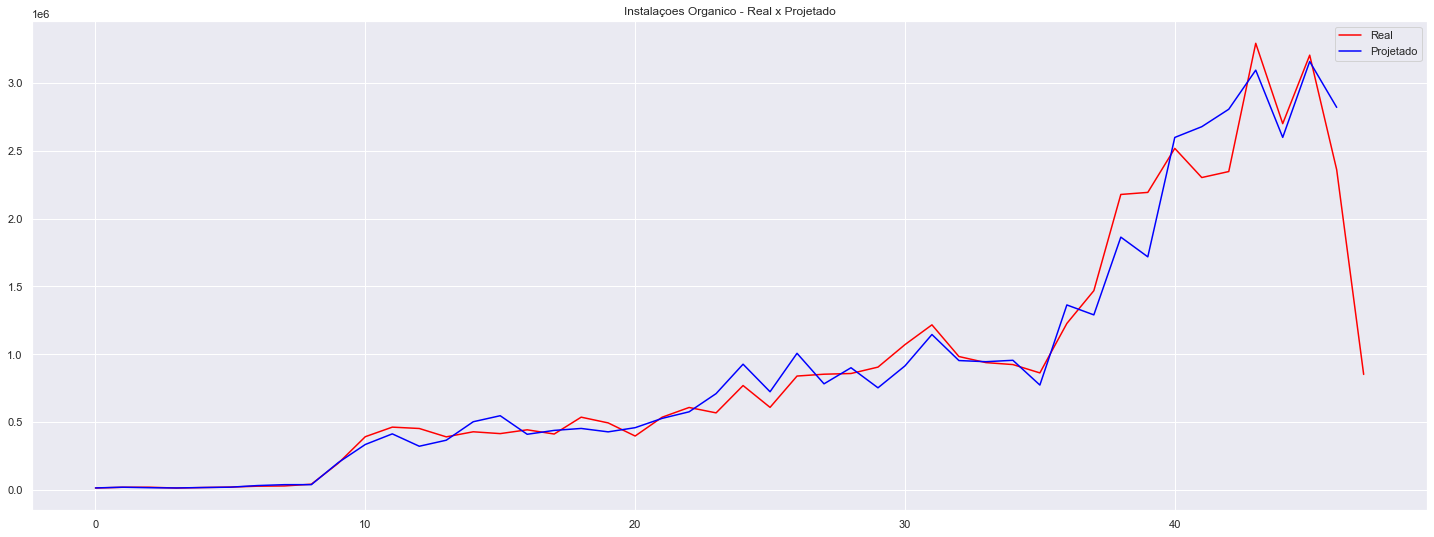

In [90]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Instalaçoes Organico - Real x Projetado')

## Observando mais variáveis 

### Houve efeito Covid?

Text(0.5, 1.0, 'Instalações organico')

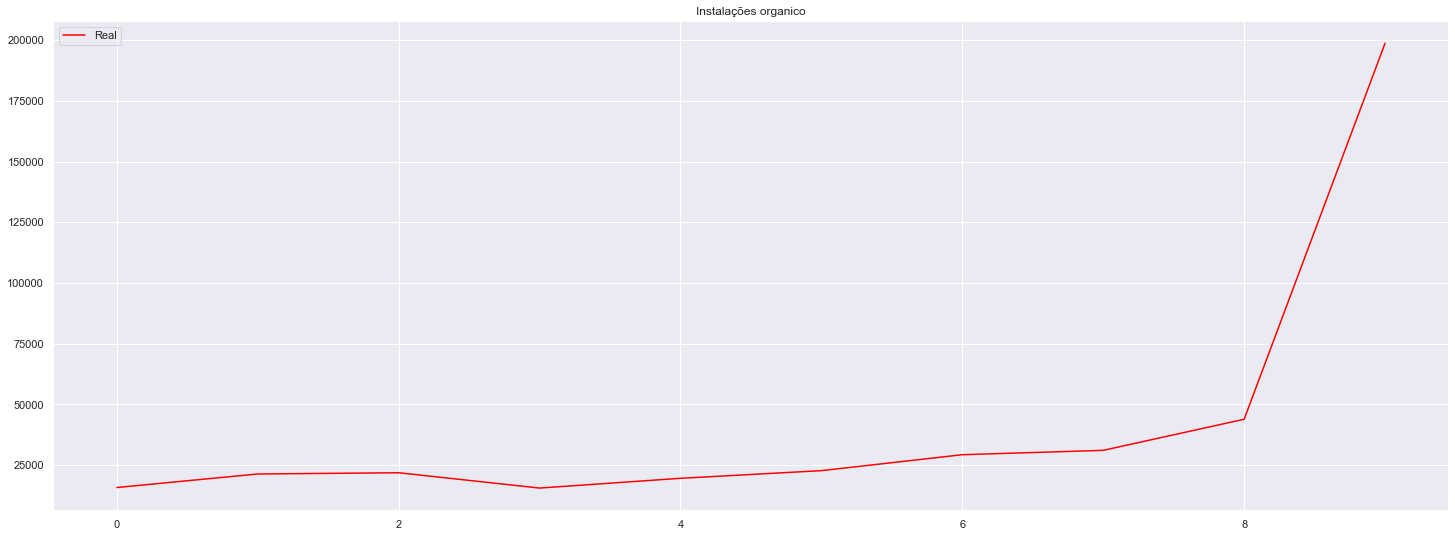

In [98]:
plt.figure(figsize=(25,9))
plt.plot(df['install_organico'].head(10), color = 'red', label = 'Real')
plt.legend()
plt.title('Instalações organico')

### Base de eventos

In [63]:
query_eventos = '''
select 
concat(substring(cast(dt_date as varchar), 1, 7), '-01') as dt_mes_evento
, count(case when ds_day_of_week = 'Dom' then dt_date end) as qtos_domingos
, max(case when ds_holiday_or_event = 'Carnaval' then 1 end) as flag_carnaval
, sum(is_holiday) as qt_feriados
, sum(is_holiday_or_event) as qt_feriados_ou_comercial
from customer_curated_zone.ca_dict_events
where dt_date >= date('2020-01-01')
group by 1
order by 1

'''


In [64]:
eventos = ac.df_athena('flavia-costa', query_eventos)

In [65]:
for column in eventos.columns:
    eventos[column].fillna(0, inplace = True)

In [66]:
eventos = eventos.rename(columns = {'dt_mes_evento': 'mes_instalacao'})

In [106]:
eventos.head()

,mes_instalacao,qtos_domingos,flag_carnaval,qt_feriados,qt_feriados_ou_comercial
0,2020-01-01,4,0.0,1,1
1,2020-02-01,4,1.0,2,2
2,2020-03-01,5,1.0,0,1
3,2020-04-01,4,0.0,2,3
4,2020-05-01,5,0.0,1,2


In [107]:
df = df.join(eventos.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [108]:
df.head()

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,...,ln_install_novos_canais,ln_install_mgm,ma_ln_install_mgm,Date,ipca,igpm,qtos_domingos,flag_carnaval,qt_feriados,qt_feriados_ou_comercial
0,2020-01-01,15718,0,0,0,239,383,2020-01-01,2020,01,...,0.0,5.948035,NaN,2020-01,0.21,0.48,4,0.0,1,1
1,2020-02-01,21295,0,0,0,611,441,2020-02-01,2020,02,...,0.0,6.089045,6.021023,2020-02,0.25,-0.04,4,1.0,2,2
2,2020-03-01,21803,0,0,0,273,356,2020-03-01,2020,03,...,0.0,5.874931,5.987707,2020-03,0.07,1.24,5,1.0,0,1
3,2020-04-01,15492,0,0,0,151,406,2020-04-01,2020,04,...,0.0,6.006353,5.942799,2020-04,-0.31,0.80,4,0.0,2,3
4,2020-05-01,19515,0,127,0,86,472,2020-05-01,2020,05,...,0.0,6.156979,6.084499,2020-05,-0.38,0.28,5,0.0,1,2


In [109]:
df.dtypes

mes_instalacao                       object
install_organico                      int64
install_ecred                         int64
install_midias_sociais                int64
install_novos_canais                  int64
install_repescagem                    int64
install_mgm                           int64
mes_instalacao_dt            datetime64[ns]
ano                                  object
mes                                  object
ln_install_organico                 float64
ln_install_midias_sociais           float64
ln_install_novos_canais             float64
ln_install_mgm                      float64
ma_ln_install_mgm                   float64
Date                              period[M]
ipca                                float64
igpm                                float64
qtos_domingos                         int64
flag_carnaval                       float64
qt_feriados                           int64
qt_feriados_ou_comercial              int64
dtype: object

In [110]:
df['flag_will'] = np.where((df['mes_instalacao_dt'] >= '2020-11-01'), 1, 0 )

In [111]:
df['flag_will'].value_counts()

1    38
0    10
Name: flag_will, dtype: int64

In [112]:
df['flag_covid'] = np.where((df['mes_instalacao_dt'] >= '2020-03-01') &
   (df['mes_instalacao_dt'] < '2020-06-01'), 1, 0 )

df['flag_covid'].value_counts()

0    45
1     3
Name: flag_covid, dtype: int64

### Modelo com demais sazonais

In [113]:
formula_text = ("""
    ln_install_organico ~ 
    ln_install_mgm + 
    ln_install_novos_canais + 
    ln_install_midias_sociais +
    flag_will +
    flag_covid +
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +        
    ipca +
    igpm +
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_install_organico   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.987
Method:                  Least Squares   F-statistic:                     145.1
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):           3.96e-19
Time:                         16:24:30   Log-Likelihood:                 31.178
No. Observations:                   47   AIC:                            -12.36
Df Residuals:                       22   BIC:                             33.90
Df Model:                           24                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [114]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['install_organico']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  10.482466170798215


Text(0.5, 1.0, 'Instalaçoes Organico - Real x Projetado')

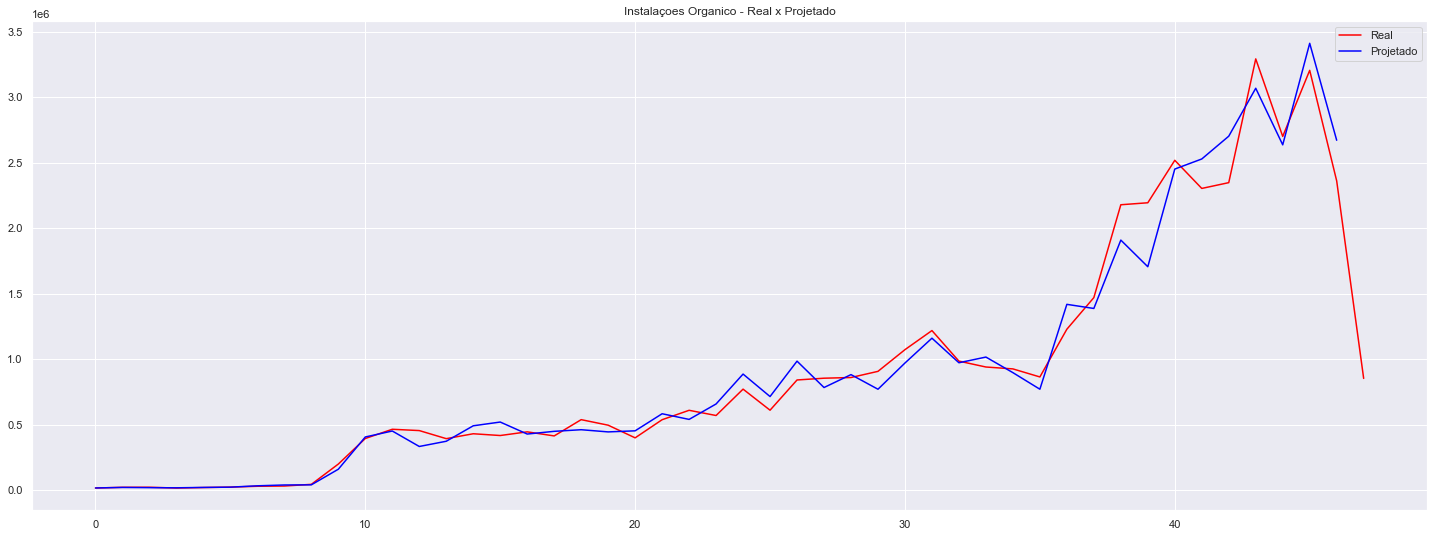

In [115]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Instalaçoes Organico - Real x Projetado')

In [134]:
!pip install pandas==1.4.4

     |████████████████████████████████| 11.7 MB 5.2 MB/s eta 0:00:01
ERROR: texthero 1.1.0 has requirement spacy<3.0.0, but you'll have spacy 3.6.0 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.3
    Uninstalling pandas-1.4.3:
      Successfully uninstalled pandas-1.4.3


In [138]:
df.tail(12)

,mes_instalacao,install_organico,install_ecred,install_midias_sociais,install_novos_canais,install_repescagem,install_mgm,mes_instalacao_dt,ano,mes,...,ma_ln_install_mgm,Date,ipca,igpm,qtos_domingos,flag_carnaval,qt_feriados,qt_feriados_ou_comercial,flag_will,flag_covid
36,2023-01-01,1227849,0,650907,1043324,64677,116595,2023-01-01,2023,01,...,11.596241,2023-01,0.53,0.21,5,0.0,1,1,1,0
37,2023-02-01,1469051,0,427015,1984891,56488,94687,2023-02-01,2023,02,...,11.567802,2023-02,0.84,-0.06,4,1.0,2,2,1,0
38,2023-03-01,2177855,0,598678,2282943,85527,132074,2023-03-01,2023,03,...,11.638505,2023-03,0.71,0.05,4,0.0,0,1,1,0
39,2023-04-01,2192987,0,598255,2471444,53772,147041,2023-04-01,2023,04,...,11.846232,2023-04,0.61,-0.95,5,0.0,2,3,1,0
40,2023-05-01,2517137,0,584937,1127394,67473,219332,2023-05-01,2023,05,...,12.118260,2023-05,0.23,-1.84,4,0.0,1,2,1,0
41,2023-06-01,2302416,0,687478,922056,59260,229721,2023-06-01,2023,06,...,12.321749,2023-06,-0.08,-1.93,4,0.0,1,2,1,0
42,2023-07-01,2346569,0,753104,1737109,56007,282071,2023-07-01,2023,07,...,12.452526,2023-07,0.12,-0.72,5,0.0,0,0,1,0
43,2023-08-01,3291091,1567,750346,1088925,19473,325063,2023-08-01,2023,08,...,12.623358,2023-08,0.23,-0.14,4,0.0,0,1,1,0
44,2023-09-01,2699344,1557,744535,525968,56217,320280,2023-09-01,2023,09,...,12.684390,2023-09,0.26,0.37,4,0.0,1,1,1,0
45,2023-10-01,3203736,14,461103,348528,76208,345041,2023-10-01,2023,10,...,12.714878,2023-10,0.24,0.50,5,0.0,1,1,1,0


In [137]:
df.to_csv('dados_actual.csv', index = False)

TypeError: __init__() got an unexpected keyword argument 'line_terminator'

### Testando Prophet 

In [150]:
!pip install prophet

     |████████████████████████████████| 14.4 MB 342 kB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.1 MB/s  eta 0:00:01
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [106]:
query_diaria = """

select 
cast(dt_first_install as date) as dt_instalacao
, count(distinct case when nm_media_source_appsflyer_group_big = 'organico' then id_appsflyer end) as install_organico
, count(distinct case when nm_media_source_appsflyer_group_big = 'midias sociais' then id_appsflyer end) as install_midias_sociais
, count(distinct case when nm_media_source_appsflyer_group_big = 'novos canais' then id_appsflyer end) as install_novos_canais
, count(distinct case when nm_media_source_appsflyer_group_big = 'mgm' then id_appsflyer end) as install_mgm
from 
growth_curated_zone.appsflyer_install
where dt_first_install < date('2023-12-01')
group by 1
order by 1

"""

In [107]:
df2 = ac.df_athena('flavia-costa', query_diaria)

In [16]:
df2.columns  

Index(['dt_instalacao', 'install_organico', 'install_midias_sociais',
       'install_novos_canais', 'install_mgm'],
      dtype='object')

In [17]:
df2.dtypes

dt_instalacao             object
install_organico           int64
install_midias_sociais     int64
install_novos_canais       int64
install_mgm                int64
dtype: object

In [6]:
from prophet import Prophet

### Organico

18:26:36 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing


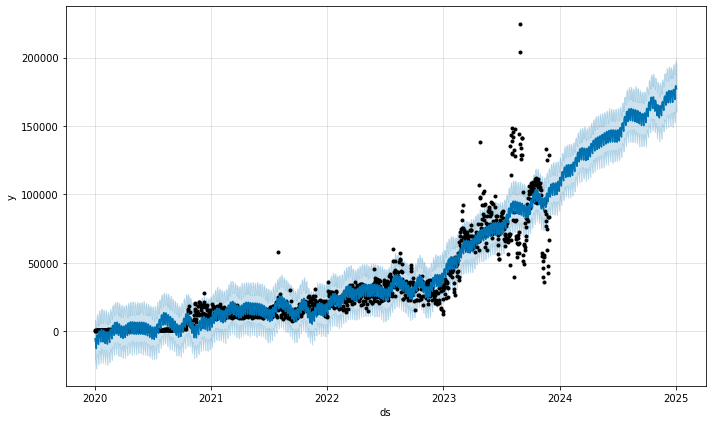

In [18]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_organico']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_organico': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

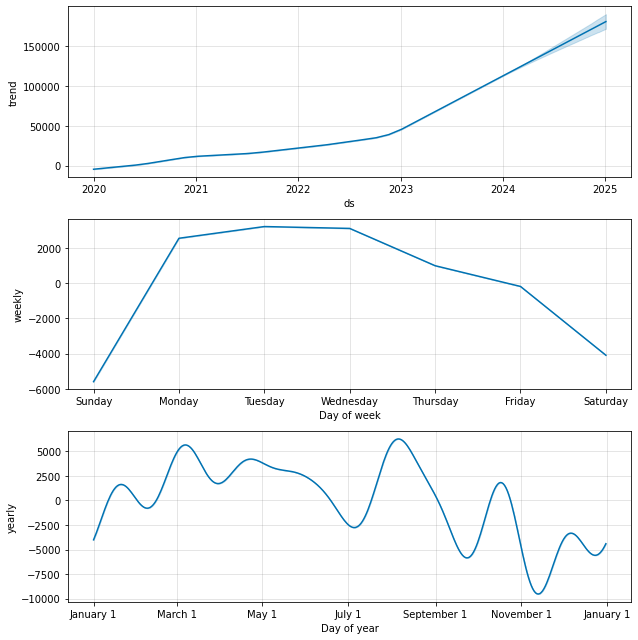

In [19]:
fig2 = m.plot_components(forecast)

In [20]:
forecast.to_csv('organico_forecast_profet.csv')

### MGM

18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing


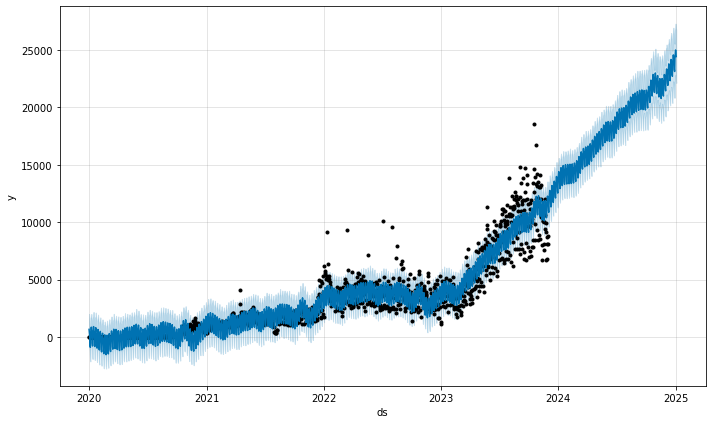

In [21]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_mgm']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_mgm': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

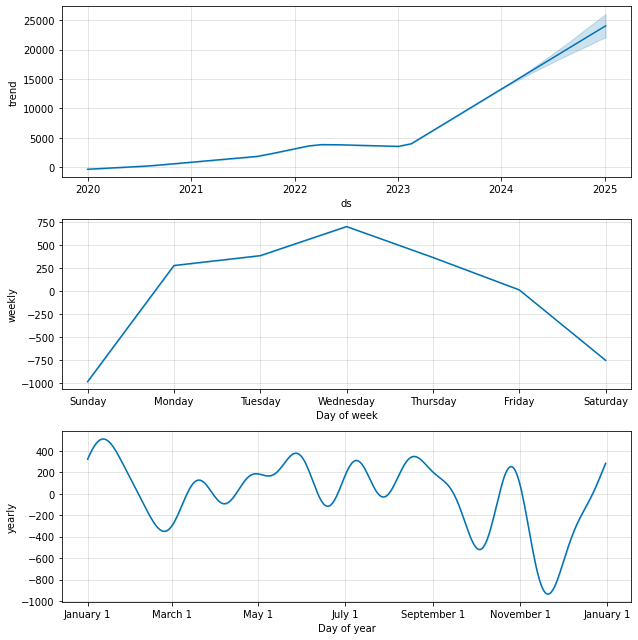

In [22]:
fig2 = m.plot_components(forecast)

In [23]:
forecast.to_csv('organico_forecast_profet.csv')

### novos canais

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing


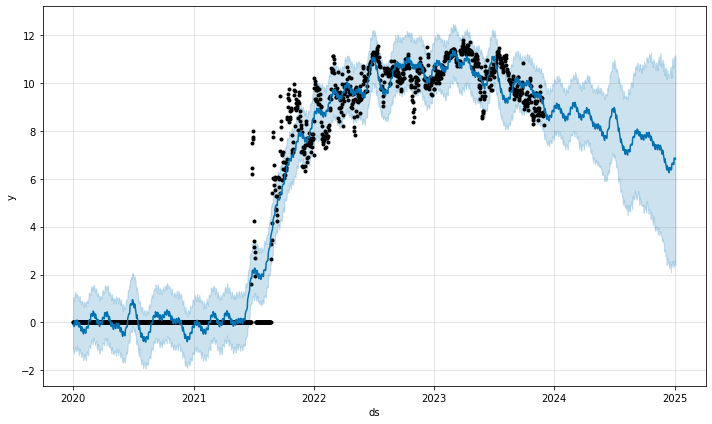

In [110]:
m = Prophet()
df2['ln_novos_canais'] = np.log(df2['install_novos_canais'])
df2 = df2.replace([np.nan, -np.inf], 0)
df_temp = df2[['dt_instalacao', 'ln_novos_canais']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'ln_novos_canais': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

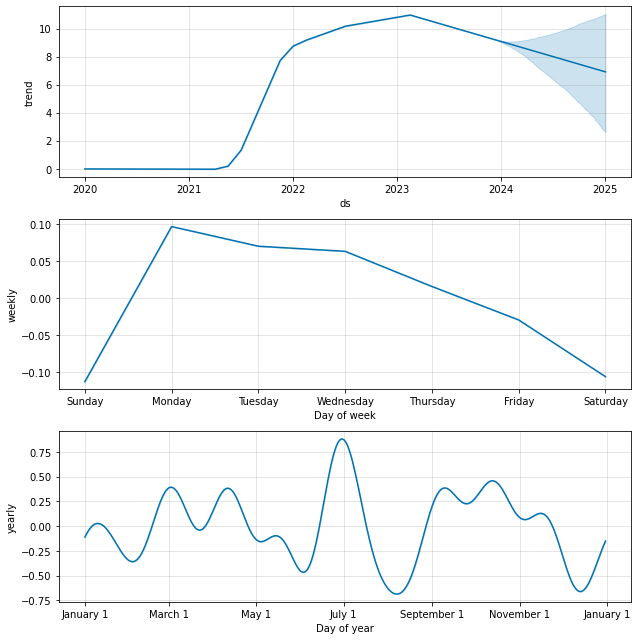

In [111]:
fig2 = m.plot_components(forecast)

In [112]:
forecast.to_csv('organico_forecast_profet.csv')

### Mídias Sociais

18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing


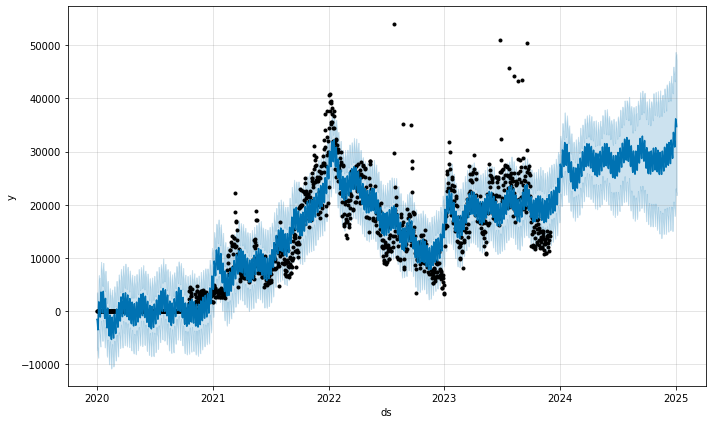

In [27]:
m = Prophet()
df_temp = df2[['dt_instalacao', 'install_midias_sociais']]
df_temp = df_temp.rename(columns={'dt_instalacao': 'ds', 'install_midias_sociais': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=400)
forecast = m.predict(future)
fig1 = m.plot(forecast)

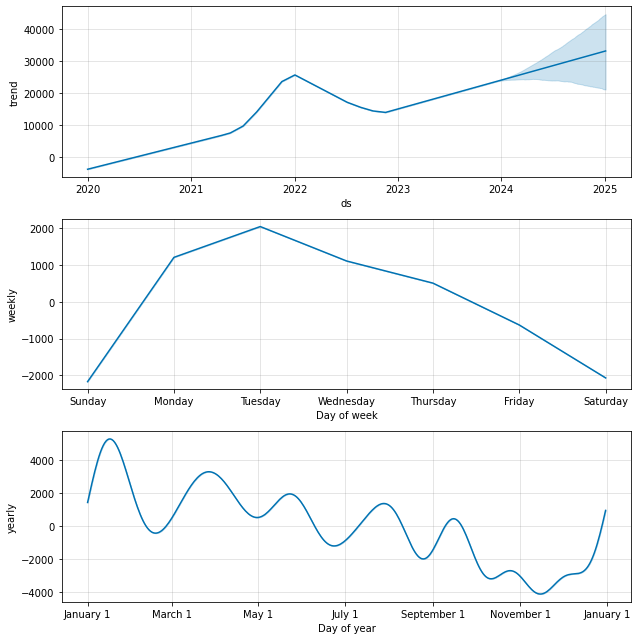

In [28]:
fig2 = m.plot_components(forecast)

In [29]:
forecast.to_csv('organico_forecast_profet.csv')

### Modelando relação entre instalações e propostas - orgânico

In [38]:
query_prop = """

Select
concat(substring(cast(dt_created_user as varchar), 1, 7), '-01') as mes_instalacao
, count(distinct case when nm_media_source_appsflyer_group = 'organico' then id_proposal end) as propostas_organico
from 
growth_curated_zone.proposal_media
where dt_created_user >= date('2022-01-01')
and dt_created_user < date('2023-12-01')
group by 1
order by 1

"""

In [39]:
propostas = ac.df_athena('flavia-costa', query_prop)

In [40]:
propostas.head()

,mes_instalacao,propostas_organico
0,2022-01-01,334055
1,2022-02-01,244699
2,2022-03-01,309457
3,2022-04-01,353962
4,2022-05-01,346594


In [102]:
propostas.tail(15)

,mes_instalacao,propostas_organico
8,2022-09-01,321568
9,2022-10-01,253351
10,2022-11-01,330915
11,2022-12-01,292707
12,2023-01-01,377645
13,2023-02-01,276092
14,2023-03-01,324745
15,2023-04-01,323738
16,2023-05-01,442645
17,2023-06-01,500021


In [52]:
df3 = propostas.join(df[['mes_instalacao', 'install_organico']].set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

<Figure size 1440x720 with 0 Axes>

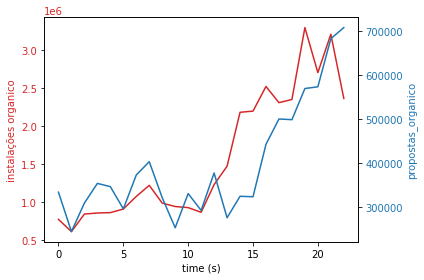

In [54]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('instalações organico', color=color)
ax1.plot(df3['install_organico'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('propostas_organico', color=color)  # we already handled the x-label with ax1
ax2.plot(df3['propostas_organico'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

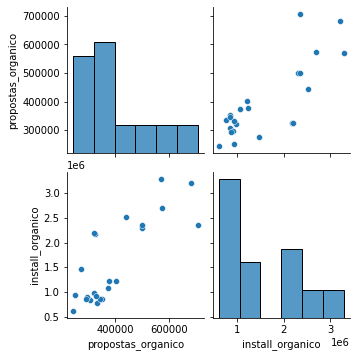

In [55]:
sns.pairplot(df3[['propostas_organico', 'install_organico']])
plt.show()

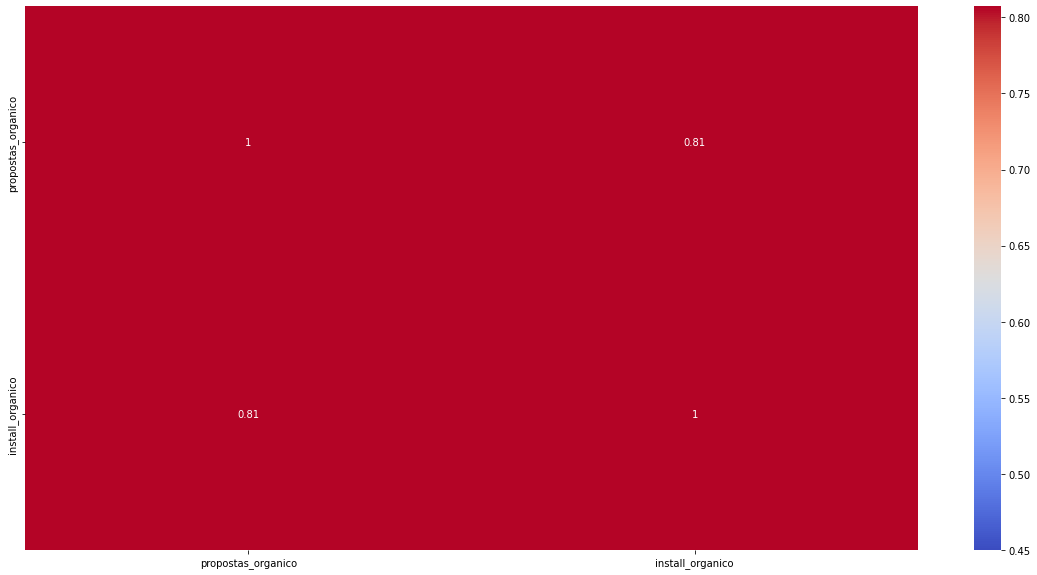

In [56]:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [57]:
df3['ln_install_organico'] = np.log(df3['install_organico'])
df3['ln_propostas_organico'] = np.log(df3['propostas_organico'])

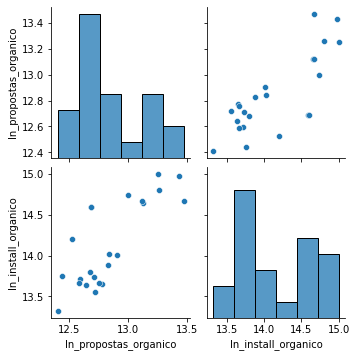

In [58]:
sns.pairplot(df3[['ln_propostas_organico', 'ln_install_organico']])
plt.show()

In [60]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.625
Model:                               OLS   Adj. R-squared:                  0.607
Method:                    Least Squares   F-statistic:                     34.98
Date:                   Tue, 19 Dec 2023   Prob (F-statistic):           7.18e-06
Time:                           10:41:49   Log-Likelihood:                 6.7503
No. Observations:                     23   AIC:                            -9.501
Df Residuals:                         21   BIC:                            -7.230
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [61]:
df3['mes_instalacao_dt'] = pd.to_datetime(df3['mes_instalacao'])
df3['ano'] = df3['mes_instalacao_dt'].map(lambda x: x.strftime('%Y'))
df3['mes'] = df3['mes_instalacao_dt'].map(lambda x: x.strftime('%m'))

In [62]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico +
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.801
Model:                               OLS   Adj. R-squared:                  0.513
Method:                    Least Squares   F-statistic:                     2.779
Date:                   Tue, 19 Dec 2023   Prob (F-statistic):             0.0649
Time:                           10:43:46   Log-Likelihood:                 14.016
No. Observations:                     23   AIC:                          -0.03282
Df Residuals:                          9   BIC:                             15.86
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [67]:
df3 = df3.join(eventos.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [70]:
formula_text = ("""
    ln_propostas_organico ~ 
    ln_install_organico + 
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial + 
    C(ano) + 
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_propostas_organico   R-squared:                       0.852
Model:                               OLS   Adj. R-squared:                  0.456
Method:                    Least Squares   F-statistic:                     2.152
Date:                   Tue, 19 Dec 2023   Prob (F-statistic):              0.176
Time:                           10:47:13   Log-Likelihood:                 17.413
No. Observations:                     23   AIC:                           -0.8259
Df Residuals:                          6   BIC:                             18.48
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

#### Testando modelagem do percentual

In [71]:
df3['perc_propostas'] = df3['propostas_organico'] / df3['install_organico']

Text(0.5, 1.0, 'Percentual de propostas')

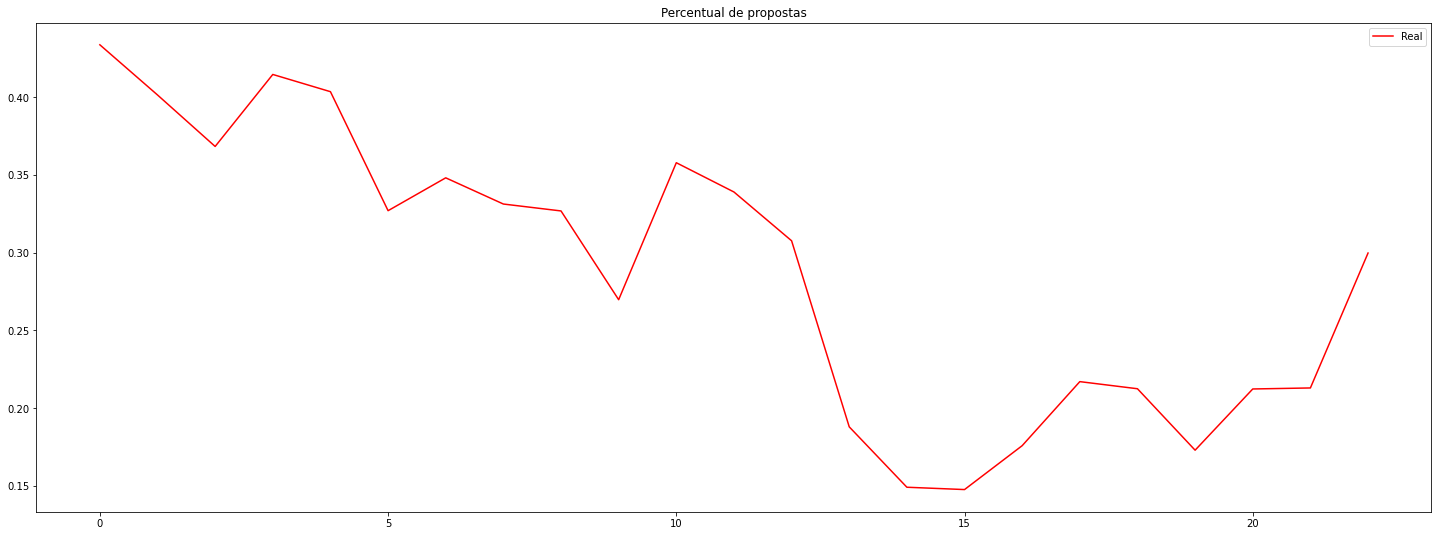

In [73]:
plt.figure(figsize=(25,9))
plt.plot(df3['perc_propostas'], color = 'red', label = 'Real')
plt.legend()
plt.title('Percentual de propostas')

In [95]:
formula_text = ("""
    perc_propostas ~
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial + 
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     3.954
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0368
Time:                        11:17:26   Log-Likelihood:                 48.779
No. Observations:                  23   AIC:                            -65.56
Df Residuals:                       7   BIC:                            -47.39
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [104]:
formula_text = ("""
    perc_propostas ~
    qtos_domingos	+
    flag_carnaval + 
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     4.230
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0233
Time:                        11:38:26   Log-Likelihood:                 47.398
No. Observations:                  23   AIC:                            -64.80
Df Residuals:                       8   BIC:                            -47.76
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5421      0.264      2.

In [79]:
ifl_month = pd.read_csv('ifl_month.csv')

In [81]:
df3 = df3.join(ifl_month.set_index('mes_instalacao'), on = 'mes_instalacao', how = 'left')

In [85]:
df3['ipca'] = df3['ipca'].str.replace(',', '.').astype('float')

<Figure size 1440x720 with 0 Axes>

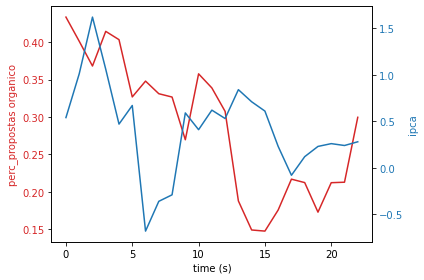

In [86]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('perc_propostas organico', color=color)
ax1.plot(df3['perc_propostas'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ipca', color=color)  # we already handled the x-label with ax1
ax2.plot(df3['ipca'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [93]:
formula_text = ("""
    perc_propostas ~
    qtos_domingos	+
    flag_carnaval + 
    qt_feriados	+ 
    qt_feriados_ou_comercial +
    ipca + 
    C(ano) +
    C(mes)
        
    """)

model = smf.ols(formula = formula_text, data = df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         perc_propostas   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     3.191
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0793
Time:                        11:17:17   Log-Likelihood:                 48.823
No. Observations:                  23   AIC:                            -63.65
Df Residuals:                       6   BIC:                            -44.34
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [98]:
prediction = model.predict(df3) #sem exp
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df3['perc_propostas']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  8.156177084839845


Text(0.5, 1.0, 'Percentual de propostas Organico')

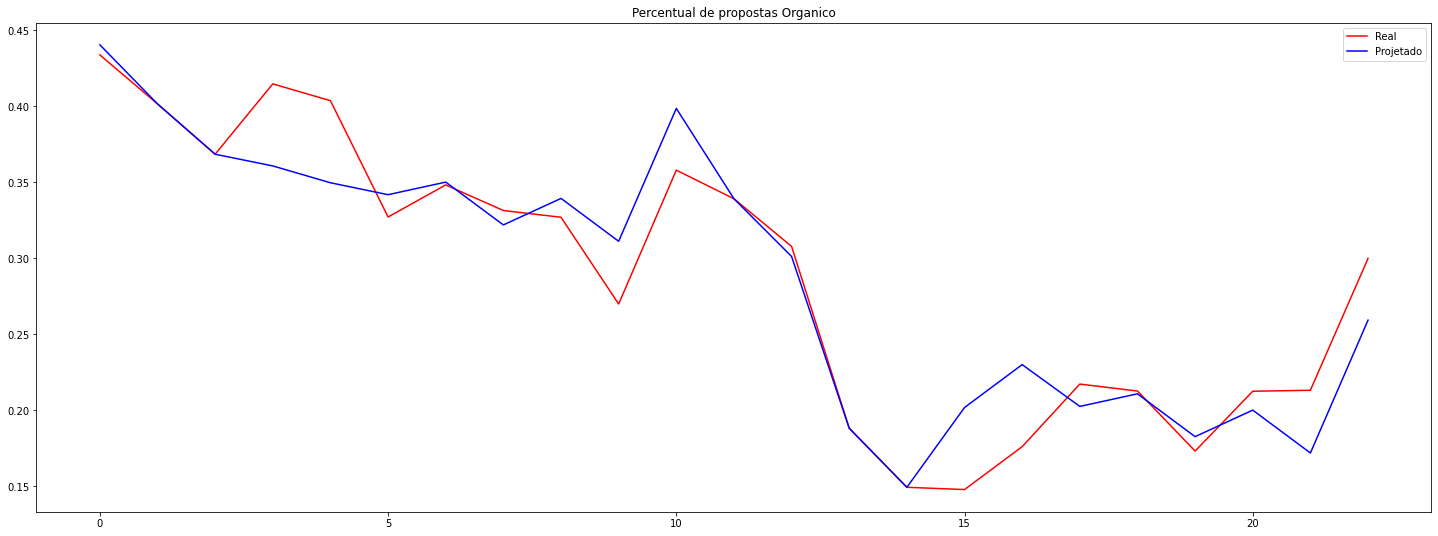

In [99]:
plt.figure(figsize=(25,9))
plt.plot(projecao_final['real'], color = 'red', label = 'Real')
plt.plot(projecao_final['prediction_test'], color = 'blue', label = 'Projetado')
plt.legend()
plt.title('Percentual de propostas Organico')

### teste prophet

11:15:08 - cmdstanpy - INFO - Chain [1] start processing


11:15:09 - cmdstanpy - INFO - Chain [1] done processing


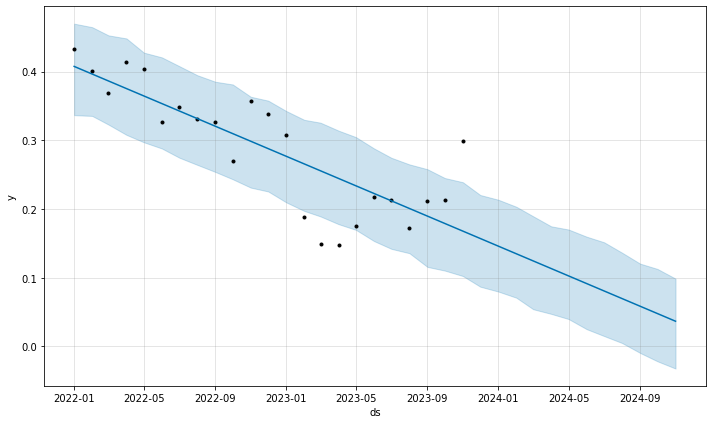

In [91]:
m = Prophet(seasonality_mode='multiplicative')
df_temp = df3[['mes_instalacao', 'perc_propostas']]
df_temp = df_temp.rename(columns={'mes_instalacao': 'ds', 'perc_propostas': 'y'})
m.fit(df_temp)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)
fig1 = m.plot(forecast)